In [1]:
import requests
import pandas as pd
from pandas import read_sql
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pymysql as mdb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
import seaborn as sns

In [2]:
def datetime2str2(t):
    return "%4d%02d%02d"%(t.year,t.month,t.day,)
    
def gen_feat(into):
    unit=6667
    avg=np.average(into)
    if avg==0: avg=1
    #chfl=-(into[0]-into[len(into)-1])/avg
    avgdiff=np.average(np.diff(into))/avg
    #diffmm=np.sign(np.argmax(into)-np.argmin(into))*(max(into)-min(into))/avg
    #maxv= np.max(into)/avg
    #minv= np.min(into)
    #rmsv= np.std(into)
    #difxv=np.max(np.diff(into))
    #difnv=np.min(np.diff(into))
    #pop=[avg,maxv]
    #change=[chfl,avgdiff,diffmm]
    #change=[chfl,diffmm]
    #consis=[rmsv/avg,np.std(np.diff(into))]
    return([avg,avgdiff])

In [10]:

def find_outliers(datestart,dateend,plot=False,cut=-0.05):
    numtopics=84

    di=datetime2str2(datestart)
    dfin=datetime2str2(dateend)

    #print di,dfin
    if dfin<di:
        temp=dfin
        dfin=di
        di=temp
    #print di,dfin
    
    afile="/Users/abramvandergeest/mysql_insightwiki_auth.txt"
    a=open(afile)
    passwd=a.readline().rstrip()
    a.close()
    host='localhost'; user='abram.ghost';db='wikidata'
    con = mdb.connect(host, user, passwd, db,port=3307)
     
    with con:
        curt= con.cursor()
        #sql="SELECT COUNT(*) FROM `topics` "
        
        sql="SELECT `Id`,`topic_label`,`topic_string` FROM `topics`;"
        curt.execute(sql)
        topics=[[0,'nothing','Filler to match index']]
        for topic in curt:
            topics.append(topic)

    data={}
        
    df=range(numtopics+1)
    with con:
        curt= con.cursor()
        sql="SELECT `Id`,`topic_label`,`topic_string` FROM `topics`;"
        curt.execute(sql)
        for row in curt:
            cur = con.cursor()
            sql='''SELECT `page_views`.`dateonly` AS `vd`, AVG(`page_views`.`count`) AS `vc`, 
                `topics`.`topic_label`,`topics`.`topic_string` 
                FROM `topics` INNER JOIN `page_views` ON `topics`.`ID` = `page_views`.`topic_id` 
                WHERE `topic_id`=%s GROUP BY `page_views`.`dateonly`   '''
            data[row[1]]=read_sql(sql, con,params=[row[0]])
            df[row[0]]=data[row[1]]
    
    topicdata=df
    
    d=topicdata[topics[3][0]]
    p=d[ (d['vd']>di) & (d['vd']<dfin )]['vc'].values    
    topicdata=df
    
    #initializing array to hold the rows to cluster
    #the 0th position is fake so that my index matches the sql index
    clusinp=[]
    clusinp.append(gen_feat([0,0,0,0,0]))
    
    chinaoff=6000
    #populating my array to go into my Kmean
    for index,topic in enumerate(topics):
        #topic=list(topics[index])
        if topic[0]!=0:
            d=topicdata[topic[0]]
            ppre=d[ (d['vd']>di) & (d['vd']<dfin )]['vc'].values
            p=gen_feat(ppre)
            if topic[0]==52:
                p=gen_feat([x-chinaoff if x-chinaoff>=0 else 0 for x in ppre  ])
            clusinp.append(p)
    
    #cleaning up my array making it numpy to go into my kmean
    clusinp=np.array(clusinp)
    clusinp[0]=clusinp[5] #making sure my through away first row matches in size
    #contam=0.325
    contamfix=0.1
    
    colors = ['m', 'g', 'b']
    X1=clusinp
    xx1, yy1 = np.meshgrid(np.linspace(0, 6000, 500), np.linspace(-1.5, 1.5, 500))
    ee=EllipticEnvelope(support_fraction=1., contamination=contamfix)
    #ee=OneClassSVM(nu=contam2, gamma=0.05,kernel='rbf')
    ee.fit(clusinp)
    outliers=ee.decision_function(X1, raw_values=False)
    
    if plot==True:
        print "here"
        %matplotlib inline
        Z1 = ee.decision_function(np.c_[xx1.ravel(), yy1.ravel()])    
        Z1 = Z1.reshape(xx1.shape)
        legend1 = plt.contour(xx1, yy1, Z1, levels=[0], linewidths=2, colors='k')
        plt.scatter(X1[:, 0], X1[:, 1], color='b')
        #plt.xlim((xx1.min(), xx1.max()))
        plt.xlim((xx1.min(), xx1.max()))
        plt.ylim((yy1.min(), yy1.max()))
        plt.ylabel("Average Change (%)", fontsize=14)#,color='Gray')
        plt.xlabel("Average of Hourly Pageviews (%)", fontsize=14)#,color='Gray')
        plt.tick_params(axis='both', which='major', labelsize=14)#,colors='Gray')
        sns.despine()
        plt.show()

    out=[]
    for index,outlier in enumerate(outliers):
        row=[index,outlier,topics[index][1],clusinp[index][0],clusinp[index][1]]
        if outlier<cut and index!=0:
            out.append(row)
            #print index,outlier,topics[index][2],clusinp[index][0],clusinp[index][1]
    #out=np.array(out)
    return out

here


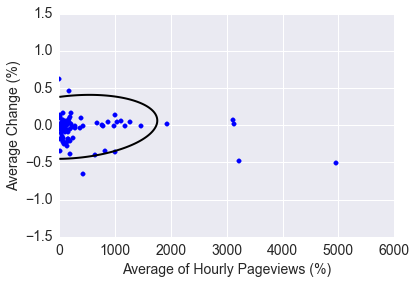

<type 'list'>
[2, -0.23432624670517122, 'Lincoln Chafee', 180.90000000000001, 0.45365763773723972]
[3, -3.5014698911757298, 'Hillary Clinton', 4964.3999999999996, -0.51412725270593296]
[7, 0.045062513881779065, 'Jeb Bush', 633.29999999999995, -0.39696826148744668]
[11, -0.86777260079203833, 'Carly Fiorina', 426.25000000000006, -0.65970674486803504]
[18, -0.029192924717633684, 'Rand Paul', 995.29999999999995, -0.35459995311296427]
[20, -2.1507976055735849, 'Marco Rubio', 3215.6000000000004, -0.48718746112700584]
[49, -1.4303729516717016, 'Syria', 3127.8999999999996, 0.018862495604079415]
[51, -0.22039973645965327, 'South Korea', 1938.1500000000001, 0.013827619121327014]
[52, -1.390128458063983, 'China', 3107.25, 0.074535360849625795]
[60, -0.9115454919251964, 'Federal Deficit', 0.75, 0.62222222222222212]


In [11]:
datestart=datetime.datetime(2015,4,17,16)
dateend=datetime.datetime(2015,4,12,16)
ol=find_outliers(datestart,dateend,plot=True,cut=0.05)

print type(ol)
def split_outliers(ol):
    #inp=np.array(ol)
    #maxch=np.max(inp[:,4])
    #print maxch
    for o in ol:
        print o
    return     

split_outliers(ol)

In [5]:

datestart=datetime.datetime(2015,4,17,16)
dateend=datetime.datetime(2015,4,12,16)
ol=find_outliers(datestart,dateend,plot=False,cut=0.05)
#for i in ol:
#    print i
 

print datetime.timedelta(days=+7)
print datestart+datetime.timedelta(days=+7)

7 days, 0:00:00
2015-04-24 16:00:00
